In [69]:
import pandas  as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

import itertools
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')
from sklearn.metrics import root_mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_theme()


# TES

In [70]:
df=pd.read_csv("D:\\INSEA\\Stage PFA\\Stage Ministère de finance\\data\\tourism\\TES_with_features.csv" )
df=df[['date','TES']]
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
df = df.asfreq('MS')  # MS = Month Start
df = df.sort_index()

## EDA

In [4]:
# df['Date'] = pd.to_datetime(df['Date'])

# # Créer la plage de dates manquantes pour 2020 (12 mois)
# missing_2020 = pd.date_range(start='2020-01-01', end='2020-12-01', freq='MS')

# # Créer un DataFrame avec les dates manquantes et valeur 0
# df_missing = pd.DataFrame({'Date': missing_2020, 'value': 0})

# # Fusionner avec ton DataFrame d'origine
# df_full = pd.concat([df, df_missing], ignore_index=True)
# df_full = df_full.sort_values('Date').reset_index(drop=True)
# df_full=df_full.drop('value',axis=1)
# df=df_full

In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 183 entries, 2010-02-01 to 2025-04-01
Freq: MS
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   TES     183 non-null    float64
dtypes: float64(1)
memory usage: 2.9 KB


In [72]:
df.describe()

,TES
count,183.000000
mean,448055.491803
std,190225.885965
min,1.000000
25%,384139.000000
50%,466513.000000
75%,542439.500000
max,966724.000000


In [73]:
# Graphique interactif
fig = px.line(
    df,
    x=df.index,
    y='TES',  # remplace 'value' par le nom réel de ta colonne
    title='Évolution mensuelle des arrivées des touristes étrangers de séjour (TES)',
)

# Personnalisation du style
#fig.update_traces(line=dict(color='sky blue', width=2), opacity=0.8)

fig.show()

In [74]:
s = pd.to_numeric(df['TES'], errors="coerce").dropna()
nbins = 30

counts, edges = np.histogram(s, bins=nbins)
w = edges[1] - edges[0]
xbar = (edges[:-1] + edges[1:]) / 2

x = np.linspace(s.min(), s.max(), 400)
kde_counts = gaussian_kde(s)(x) * len(s) * w

fig = go.Figure([
    go.Bar(x=xbar, y=counts, width=w, marker_color="#9AC2F7", marker_line=dict(color="white", width=1), name="Count"),
    go.Scatter(x=x, y=kde_counts, mode="lines",marker_color="#144E9A", line=dict(width=2), name="KDE")
])
fig.update_layout(title="Distribution de TES", xaxis_title="TES", yaxis_title="Count", template="simple_white", width=900, height=520)
fig.update_xaxes(showgrid=True)
fig.update_yaxes(showgrid=True)
fig.show()

##### Time series decomposition

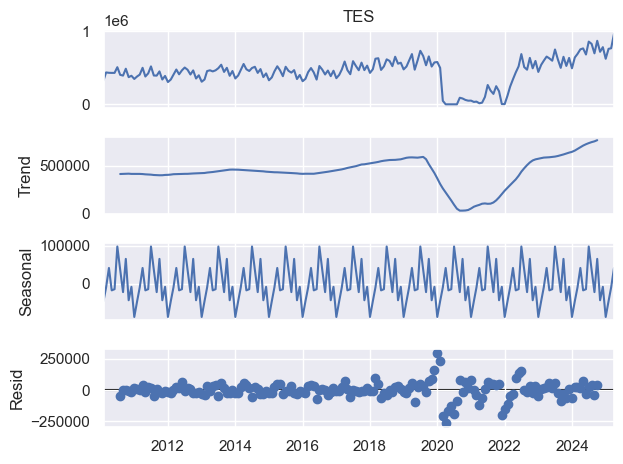

In [9]:
# Seasonal Decomposition
try:
    from statsmodels.tsa.seasonal import seasonal_decompose

    
    result = seasonal_decompose(df['TES'].dropna(), model='additive', period=12)
    result.plot()
    plt.show()
except ImportError:
    print("Statsmodels not installed. Skipping seasonal decomposition.")


#### Augmented Dickey-Fuller test

In [10]:
def test_stationnarite(serie, nom='Serie'):
    result = adfuller(serie.dropna())
    print(f'--- ADF Test fot {nom} ---')
    print(f'ADF Statistic: {result[0]:.4f}')
    print(f'p-value: {result[1]:.4f}')
    
    if result[1] <= 0.05:
        print("✓ Série STATIONNAIRE (p-value ≤ 0.05)")
    else:
        print("✗ Série NON-STATIONNAIRE (p-value > 0.05)")    

In [11]:
test_stationnarite(df['TES'], 'TES')

--- ADF Test fot TES ---
ADF Statistic: -2.3328
p-value: 0.1616
✗ Série NON-STATIONNAIRE (p-value > 0.05)


In [12]:
df['TES_diff1'] = df['TES'].diff()
test_stationnarite(df['TES_diff1'], 'TES_diff1')

--- ADF Test fot TES_diff1 ---
ADF Statistic: -2.9438
p-value: 0.0405
✓ Série STATIONNAIRE (p-value ≤ 0.05)


In [13]:
df['TES_diff2'] = df['TES'].diff().diff()
test_stationnarite(df['TES_diff2'], 'TES_diff1')

--- ADF Test fot TES_diff1 ---
ADF Statistic: -10.6150
p-value: 0.0000
✓ Série STATIONNAIRE (p-value ≤ 0.05)


In [14]:
ts_d1 = df['TES'].diff().dropna()
ts_d12 = ts_d1.diff(12).dropna()
print("ADF p-value (1st + seasonal diff):", adfuller(ts_d12)[1])

ADF p-value (1st + seasonal diff): 4.93921782051603e-07


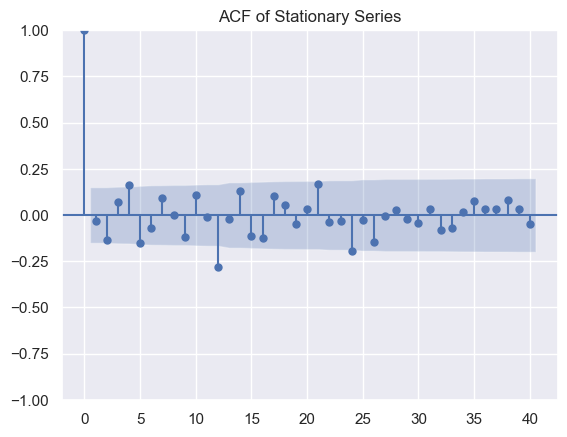

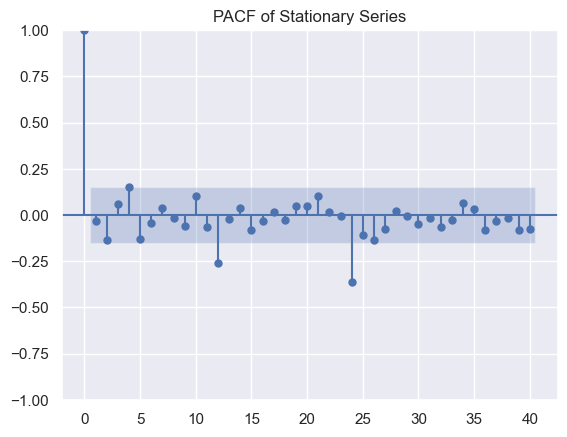

In [15]:
plot_acf(ts_d12,lags=40)
plt.title("ACF of Stationary Series")
plt.show()

plot_pacf(ts_d12,lags=40)
plt.title("PACF of Stationary Series")
plt.show()

## Modeling

In [142]:
train=df.loc['01-2010':'11-2023']
test=df.loc['12-2023':]
print("taille du train:",len(train),"\ntaille du test :",len(test))

taille du train: 166 
taille du test : 17


In [80]:
def grid_search_sarima(train_data, colonne,
                       p_range=range(0, 2), d_range=range(1,2), q_range=range(0, 2),
                       P_range=range(0, 3), D_range=range(1, 3), Q_range=range(0, 3),
                       s=[12]):
    print("\n" + "="*70)
    print("GRID SEARCH SARIMA - VERSION OPTIMISÉE")
    print("="*70)
    # Générer toutes les combinaisons
    pdq = list(itertools.product(p_range, d_range, q_range))
    seasonal_pdq = list(itertools.product(P_range, D_range, Q_range, s))
    
    total_models = len(pdq) * len(seasonal_pdq)
    print(f"\nNombre total de modèles à tester: {total_models}")
    print("Démarrage de la recherche...\n")
    # Variables pour stocker uniquement le meilleur
    meilleur_aic = np.inf
    meilleur_modele = None
    meilleur_params = None
    meilleur_params_seasonal = None
    meilleur_bic = None
    
    compteur = 0
    modeles_testes = 0
    
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            compteur += 1
            
            try:
                # Ajuster le modèle
                model = SARIMAX(train_data[colonne],
                               order=param,
                               seasonal_order=param_seasonal)
                
                results = model.fit(disp=False, maxiter=200)
                modeles_testes += 1
                
                # Garder uniquement si c'est le meilleur
                if results.aic < meilleur_aic:
                    meilleur_aic = results.aic
                    meilleur_bic = results.bic
                    meilleur_modele = results
                    meilleur_params = param
                    meilleur_params_seasonal = param_seasonal
                    
                    # Afficher quand on trouve un meilleur modèle
                    print(f"  ✓ Nouveau meilleur: SARIMA{param}x{param_seasonal} - AIC: {results.aic:.2f}")
                
                # Afficher progression
                if compteur % 10 == 0 or compteur == total_models:
                    print(f"  Progression: {compteur}/{total_models} combinaisons testées ({modeles_testes} réussies)...")
                
            except Exception as e:
                # Ignorer les modèles qui ne convergent pas
                continue
    
    # Vérifier qu'au moins un modèle a convergé
    if meilleur_modele is None:
        raise ValueError("❌ Aucun modèle n'a convergé ! Essayez avec des plages de paramètres différentes.")
    
    print("\n" + "="*70)
    print("🏆 MEILLEUR MODÈLE TROUVÉ")
    print("="*70)
    print(f"SARIMA{meilleur_params}x{meilleur_params_seasonal}")
    print(f"AIC: {meilleur_aic:.2f}")
    print(f"BIC: {meilleur_bic:.2f}")
    print(f"\nModèles testés avec succès: {modeles_testes}/{total_models}")
    
    return {
        'params': meilleur_params,
        'seasonal_params': meilleur_params_seasonal,
        'aic': meilleur_aic,
        'bic': meilleur_bic,
        'model': meilleur_modele
    }

#####  optimal orders

In [81]:
meilleur = grid_search_sarima(train,'TES')


GRID SEARCH SARIMA - VERSION OPTIMISÉE

Nombre total de modèles à tester: 72
Démarrage de la recherche...

  ✓ Nouveau meilleur: SARIMA(0, 1, 0)x(0, 1, 0, 12) - AIC: 3925.75
  ✓ Nouveau meilleur: SARIMA(0, 1, 0)x(0, 1, 1, 12) - AIC: 3892.38
  ✓ Nouveau meilleur: SARIMA(0, 1, 0)x(0, 2, 0, 12) - AIC: 3757.31
  ✓ Nouveau meilleur: SARIMA(0, 1, 0)x(0, 2, 1, 12) - AIC: 3670.19
  Progression: 10/72 combinaisons testées (10 réussies)...
  ✓ Nouveau meilleur: SARIMA(0, 1, 0)x(1, 2, 1, 12) - AIC: 3663.10
  ✓ Nouveau meilleur: SARIMA(0, 1, 0)x(2, 2, 1, 12) - AIC: 3651.38
  Progression: 20/72 combinaisons testées (20 réussies)...
  Progression: 30/72 combinaisons testées (30 réussies)...
  Progression: 40/72 combinaisons testées (40 réussies)...
  Progression: 50/72 combinaisons testées (50 réussies)...
  Progression: 60/72 combinaisons testées (60 réussies)...
  Progression: 70/72 combinaisons testées (70 réussies)...
  Progression: 72/72 combinaisons testées (72 réussies)...

🏆 MEILLEUR MODÈLE

##### Fiting Models

In [82]:
model = SARIMAX(train["TES"],order=meilleur['params'],seasonal_order=meilleur['seasonal_params'])
results = model.fit(disp=False)
print(results.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                  TES   No. Observations:                  166
Model:             SARIMAX(0, 1, 0)x(2, 2, [1], 12)   Log Likelihood               -1821.689
Date:                              Wed, 26 Nov 2025   AIC                           3651.378
Time:                                      22:14:31   BIC                           3663.173
Sample:                                  02-01-2010   HQIC                          3656.171
                                       - 11-01-2023                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.3935      0.138     -2.858      0.004      -0.663      -0.124
ar.S.L24      -0.28

##### Predictions / Metrics  

In [83]:
predictions = results.predict(start=test.index[0], end=test.index[-1])

rmse = root_mean_squared_error(test['TES'], predictions)
r2 = r2_score(test['TES'], predictions)
mae = mean_absolute_error(test['TES'], predictions)
mape = mean_absolute_percentage_error(test['TES'], predictions)

print("="*15,"Metrics Test","="*15)
print(f"RMSE: {rmse:,.2f}")
print(f"MAE: {mae:,.2f}")
print(f"MAPE: {mape:,.2%}")
print(f"R²: {r2:,.2%}")
print(f"R²: {r2:,.4f}")

=============== Metrics Test ===============
RMSE: 100,135.47
MAE: 89,835.62
MAPE: 12.00%
R²: 13.38%
R²: 0.1338


In [85]:
predictions = results.forecast(17)

rmse = root_mean_squared_error(test['TES'], predictions)
r2 = r2_score(test['TES'], predictions)
mae = mean_absolute_error(test['TES'], predictions)
mape = mean_absolute_percentage_error(test['TES'], predictions)

print("="*15,"Metrics Test","="*15)
print(f"RMSE: {rmse:,.2f}")
print(f"MAE: {mae:,.2f}")
print(f"MAPE: {mape:,.2%}")
print(f"R²: {r2:,.2%}")
print(f"R²: {r2:,.4f}")

=============== Metrics Test ===============
RMSE: 100,135.47
MAE: 89,835.62
MAPE: 12.00%
R²: 13.38%
R²: 0.1338


##### Visualization


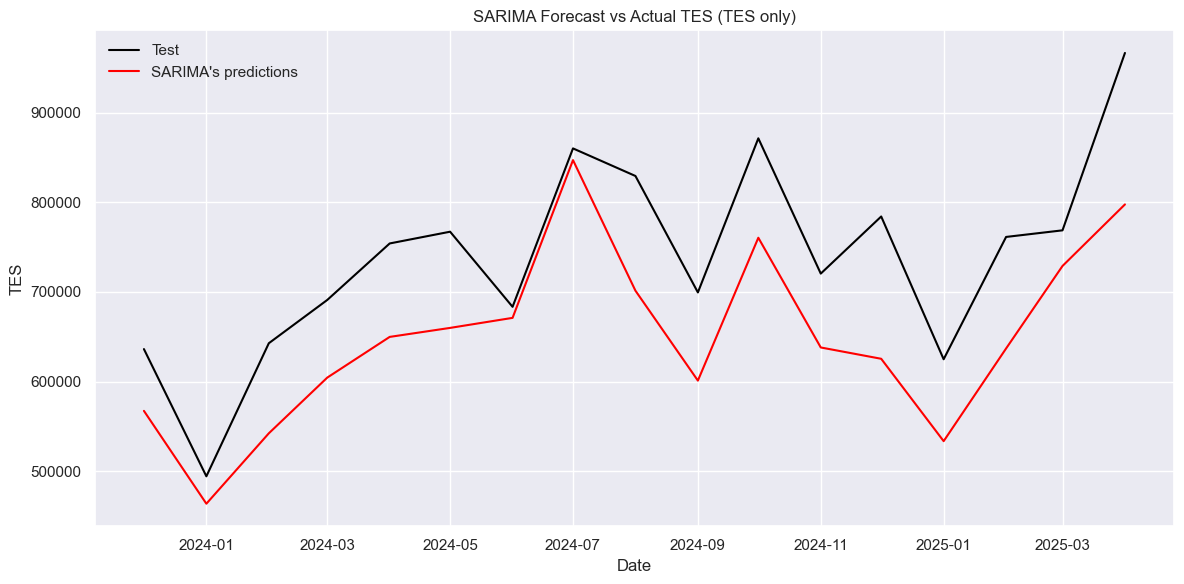

In [23]:
#Visualization
plt.figure(figsize=(12,6))
plt.plot(test.index, test['TES'], label='Test', color='black')
plt.plot(predictions.index, predictions, label='SARIMA\'s predictions', color='red')
plt.title("SARIMA Forecast vs Actual TES (TES only)")
plt.xlabel("Date")
plt.ylabel("TES")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Expanding window

In [39]:
# Expanding window avec contraintes réelles  
def forecast(df, target, test=18):
    
    train_end = len(df) - test
    preds, acts , dates = [],[], []
    train = df.iloc[:train_end ]
    for i in range(test):
        # Train
        y_train =  train[target]
        train = df.iloc[:train_end + i]
        
        model = SARIMAX(y_train,order=(0,1,0),seasonal_order=(2,2,1,12))
        results = model.fit(disp=False,maxiter=200)#, cov_type='robust')
        
        # Test avec contrainte réelle
        test_row = df.iloc[[train_end + i]].copy()
        start_index = test_row.index.min()
        end_index = test_row.index.max()
        pred = results.predict(start=start_index, end=end_index)[0]

        preds.append(pred)
        acts.append(df.iloc[train_end + i][target])
        dates.append(df.index[train_end + i])
    
    # Métriques
    mae = mean_absolute_error(acts, preds)
    rmse = root_mean_squared_error(acts, preds)
    r2 = r2_score(acts, preds)
    mape = 100 * np.mean(np.abs((np.array(acts) - np.array(preds)) / np.array(acts)))
    
    print("="*40,"Mrtric","="*40)
    print(f"MAE: {mae:,.1f} \nRMSE: {rmse:,.1f} \nMAPE: {mape:,.1f}%")
    print(f"R²: {r2:,.2f}")
    return pd.DataFrame({'actual': acts, 'predicted': preds} , index=dates)



In [40]:
results1=forecast(df,'TES', test=18)

======================================== Mrtric ========================================
MAE: 47,133.8 
RMSE: 57,966.6 
MAPE: 6.5%
R²: 0.75


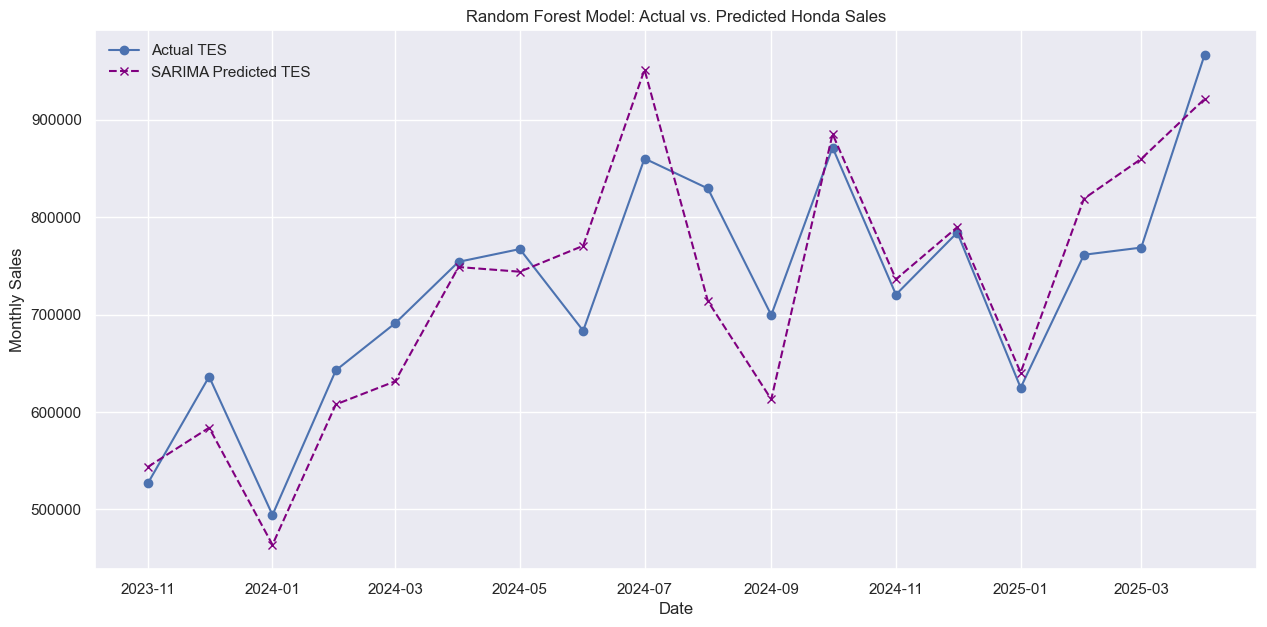

In [41]:
# Plot predictions vs. actuals
plt.figure(figsize=(15, 7))
plt.plot(results1.index, results1['actual'].values, label='Actual TES', marker='o', linestyle='-')
plt.plot(results1.index, results1['predicted'].values, label='SARIMA Predicted TES', marker='x', linestyle='--', color='purple')
plt.title('Random Forest Model: Actual vs. Predicted Honda Sales')
plt.xlabel('Date')
plt.ylabel('Monthly Sales')
plt.legend()
plt.grid(True)
plt.show()

# MRE

In [46]:
df1=pd.read_csv("D:\\INSEA\\Stage PFA\\Stage Ministère de finance\\data\\tourism\\KPI_touristique.csv" )
df1['date'] = pd.to_datetime(df1['date'])
df1.set_index('date', inplace=True)
df1 = df1.asfreq('MS')  # MS = Month Start
df1 = df1.sort_index()

In [47]:
# Graphique interactif
fig = px.line(
    df1,
    x=df1.index,
    y='MRE',  # remplace 'value' par le nom réel de ta colonne
    title='Évolution mensuelle des arrivées des touristes étrangers de séjour (TES)',
)

# Personnalisation du style
#fig.update_traces(line=dict(color='sky blue', width=2), opacity=0.8)

fig.show()

##### Time series decomposition

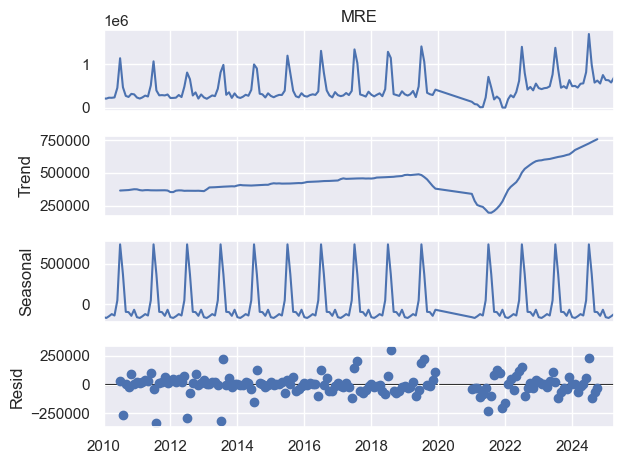

In [29]:
# Seasonal Decomposition
try:
    from statsmodels.tsa.seasonal import seasonal_decompose

    
    result = seasonal_decompose(df1['MRE'].dropna(), model='additive', period=12)
    result.plot()
    plt.show()
except ImportError:
    print("Statsmodels not installed. Skipping seasonal decomposition.")


In [30]:
test_stationnarite(df1['MRE'], 'MRE')
df1['MRE_diff1'] = df1['MRE'].diff()


--- ADF Test fot MRE ---
ADF Statistic: -1.2472
p-value: 0.6530
✗ Série NON-STATIONNAIRE (p-value > 0.05)


In [31]:
test_stationnarite(df1['MRE_diff1'], 'MRE_diff1')

--- ADF Test fot MRE_diff1 ---
ADF Statistic: -2.9757
p-value: 0.0372
✓ Série STATIONNAIRE (p-value ≤ 0.05)


In [32]:
ts_d1 = df1['MRE'].diff().dropna()
ts_d12 = ts_d1.diff(12).dropna()
print("ADF p-value (1st + seasonal diff):", adfuller(ts_d12)[1])

ADF p-value (1st + seasonal diff): 3.3305810621933713e-20


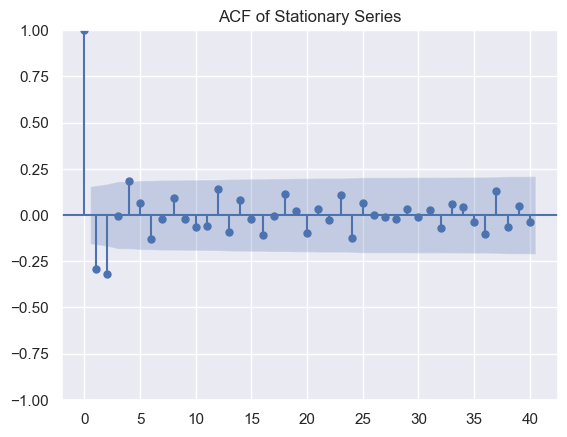

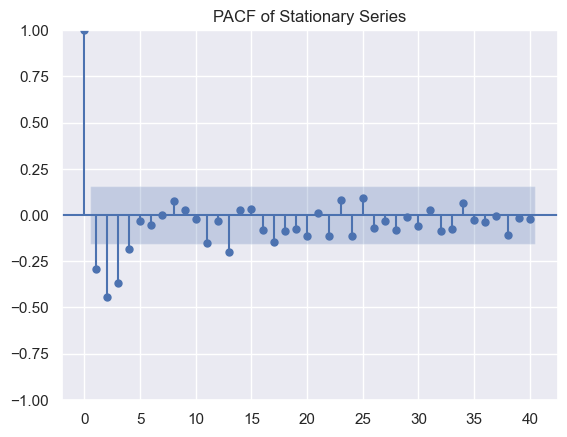

In [33]:
plot_acf(ts_d12,lags=40)
plt.title("ACF of Stationary Series")
plt.show()

plot_pacf(ts_d12,lags=40)
plt.title("PACF of Stationary Series")
plt.show()

### Modeling

In [ ]:
train_MRE=df1.loc['01-2010':'11-2023']
test_MRE=df1.loc['12-2023':'04-2025']
print("taille du train:",len(train_MRE),"\ntaille du test :",len(test_MRE))

taille du train: 167 
taille du test : 17


In [35]:
def grid_search_sarima(train_data, colonne,
                       p_range=range(0, 3), d_range=range(1,2), q_range=range(0, 3),
                       P_range=range(0, 2), D_range=range(0, 2), Q_range=range(0, 2),
                       s=[12]):
    print("\n" + "="*70)
    print("GRID SEARCH SARIMA - VERSION OPTIMISÉE")
    print("="*70)
    # Générer toutes les combinaisons
    pdq = list(itertools.product(p_range, d_range, q_range))
    seasonal_pdq = list(itertools.product(P_range, D_range, Q_range, s))
    
    total_models = len(pdq) * len(seasonal_pdq)
    print(f"\nNombre total de modèles à tester: {total_models}")
    print("Démarrage de la recherche...\n")
    # Variables pour stocker uniquement le meilleur
    meilleur_aic = np.inf
    meilleur_modele = None
    meilleur_params = None
    meilleur_params_seasonal = None
    meilleur_bic = None
    
    compteur = 0
    modeles_testes = 0
    
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            compteur += 1
            
            try:
                # Ajuster le modèle
                model = SARIMAX(train_data[colonne],
                               order=param,
                               seasonal_order=param_seasonal)
                
                results = model.fit(disp=False, maxiter=200)
                modeles_testes += 1
                
                # Garder uniquement si c'est le meilleur
                if results.aic < meilleur_aic:
                    meilleur_aic = results.aic
                    meilleur_bic = results.bic
                    meilleur_modele = results
                    meilleur_params = param
                    meilleur_params_seasonal = param_seasonal
                    
                    # Afficher quand on trouve un meilleur modèle
                    print(f"  ✓ Nouveau meilleur: SARIMA{param}x{param_seasonal} - AIC: {results.aic:.2f}")
                
                # Afficher progression
                if compteur % 10 == 0 or compteur == total_models:
                    print(f"  Progression: {compteur}/{total_models} combinaisons testées ({modeles_testes} réussies)...")
                
            except Exception as e:
                # Ignorer les modèles qui ne convergent pas
                continue
    
    # Vérifier qu'au moins un modèle a convergé
    if meilleur_modele is None:
        raise ValueError("❌ Aucun modèle n'a convergé ! Essayez avec des plages de paramètres différentes.")
    
    print("\n" + "="*70)
    print("🏆 MEILLEUR MODÈLE TROUVÉ")
    print("="*70)
    print(f"SARIMA{meilleur_params}x{meilleur_params_seasonal}")
    print(f"AIC: {meilleur_aic:.2f}")
    print(f"BIC: {meilleur_bic:.2f}")
    print(f"\nModèles testés avec succès: {modeles_testes}/{total_models}")
    
    return {
        'params': meilleur_params,
        'seasonal_params': meilleur_params_seasonal,
        'aic': meilleur_aic,
        'bic': meilleur_bic,
        'model': meilleur_modele
    }

In [36]:
meilleur_M = grid_search_sarima(train_MRE,'MRE')


GRID SEARCH SARIMA - VERSION OPTIMISÉE

Nombre total de modèles à tester: 72
Démarrage de la recherche...

  ✓ Nouveau meilleur: SARIMA(0, 1, 0)x(0, 0, 0, 12) - AIC: 4119.98
  ✓ Nouveau meilleur: SARIMA(0, 1, 0)x(0, 0, 1, 12) - AIC: 4039.57
  ✓ Nouveau meilleur: SARIMA(0, 1, 0)x(0, 1, 0, 12) - AIC: 3570.76
  ✓ Nouveau meilleur: SARIMA(0, 1, 0)x(0, 1, 1, 12) - AIC: 3563.93
  ✓ Nouveau meilleur: SARIMA(0, 1, 0)x(1, 1, 1, 12) - AIC: 3551.48
  Progression: 10/72 combinaisons testées (10 réussies)...
  ✓ Nouveau meilleur: SARIMA(0, 1, 1)x(0, 1, 0, 12) - AIC: 3530.55
  ✓ Nouveau meilleur: SARIMA(0, 1, 1)x(0, 1, 1, 12) - AIC: 3530.41
  ✓ Nouveau meilleur: SARIMA(0, 1, 1)x(1, 1, 1, 12) - AIC: 3521.89
  Progression: 20/72 combinaisons testées (20 réussies)...
  Progression: 30/72 combinaisons testées (30 réussies)...
  Progression: 40/72 combinaisons testées (40 réussies)...
  Progression: 50/72 combinaisons testées (50 réussies)...
  Progression: 60/72 combinaisons testées (60 réussies)...
  

In [47]:
model_M = SARIMAX(train_MRE["MRE"],order=meilleur_M['params'],seasonal_order=meilleur_M['seasonal_params'])
results_M = model_M.fit(disp=False)

In [48]:
predictions_MRE = results_M.predict(start=test_MRE.index[0], end=test_MRE.index[-1])

In [49]:
rmse = root_mean_squared_error(test_MRE['MRE'], predictions_MRE)
r2 = r2_score(test_MRE['MRE'], predictions_MRE)
mae = mean_absolute_error(test_MRE['MRE'], predictions_MRE)
mape = mean_absolute_percentage_error(test_MRE['MRE'], predictions_MRE)

print("="*15,"Metrics Test","="*15)
print(f"RMSE: {rmse:,.2f}")
print(f"MAE: {mae:,.2f}")
print(f"MAPE: {mape:,.2%}")
print(f"R²: {r2:,.2%}")
print(f"R²: {r2:,.4f}")

=============== Metrics Test ===============
RMSE: 111,491.54
MAE: 89,192.33
MAPE: 12.27%
R²: 84.07%
R²: 0.8407


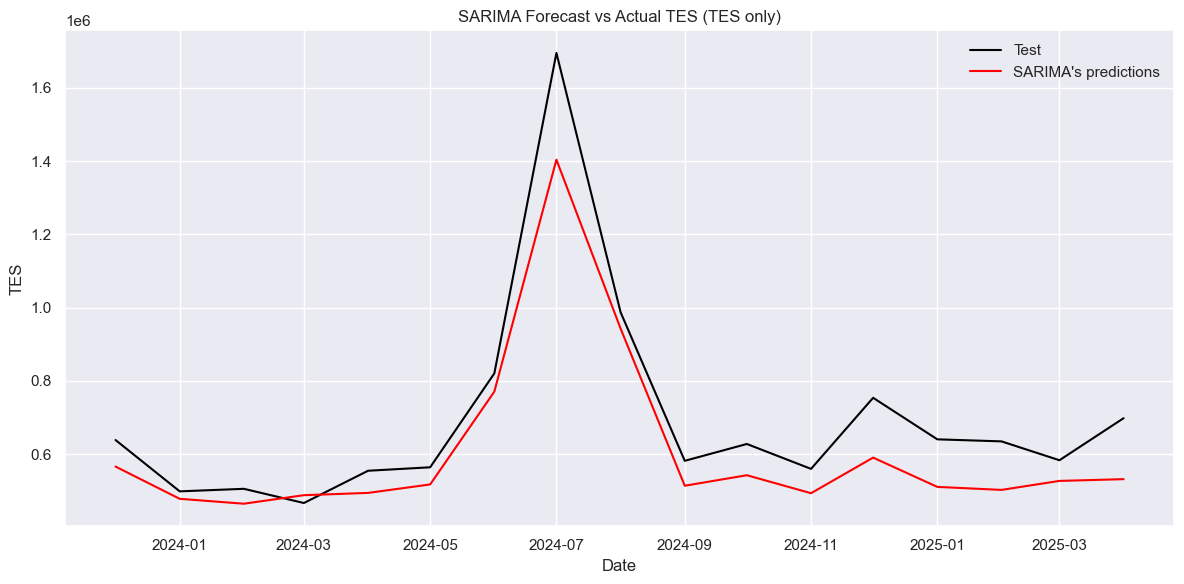

In [50]:
#Visualization
plt.figure(figsize=(12,6))
plt.plot(test_MRE.index, test_MRE['MRE'], label='Test', color='black')
plt.plot(predictions_MRE.index, predictions_MRE, label='SARIMA\'s predictions', color='red')
plt.title("SARIMA Forecast vs Actual TES (TES only)")
plt.xlabel("Date")
plt.ylabel("TES")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Expanding window

In [ ]:
# Expanding window avec contraintes réelles  
def forecast(df, target, test=18):
    
    train_end = len(df) - test
    preds, acts , dates = [],[], []
    
    for i in range(test):
        # Train
        train = df.iloc[:train_end + i]
        y_train =  train[target]
        
        model = SARIMAX(y_train,order=(0,1,1),seasonal_order=(1,1,1,12))
        results = model.fit(disp=False,maxiter=200)#, cov_type='robust')
        
        # Test avec contrainte réelle
        test_row = df.iloc[[train_end + i]].copy()
        start_index = test_row.index.min()
        end_index = test_row.index.max()
        pred = results.predict(start=start_index, end=end_index)[0]

        preds.append(pred)
        acts.append(df.iloc[train_end + i][target])
        dates.append(df.index[train_end + i])
    
    # Métriques
    mae = mean_absolute_error(acts, preds)
    rmse = root_mean_squared_error(acts, preds)
    r2 = r2_score(acts, preds)
    mape = 100 * np.mean(np.abs((np.array(acts) - np.array(preds)) / np.array(acts)))
    
    print("="*40,"Mrtric","="*40)
    print(f"MAE: {mae:,.1f} \nRMSE: {rmse:,.1f} \nMAPE: {mape:,.1f}%")
    print(f"R²: {r2:,.2f}")
    return pd.DataFrame({'actual': acts, 'predicted': preds} , index=dates)


In [43]:
results2 = forecast(df1,'MRE', test=18)

======================================== Mrtric ========================================
MAE: 43,129.3 
RMSE: 71,334.8 
MAPE: 5.4%
R²: 0.93


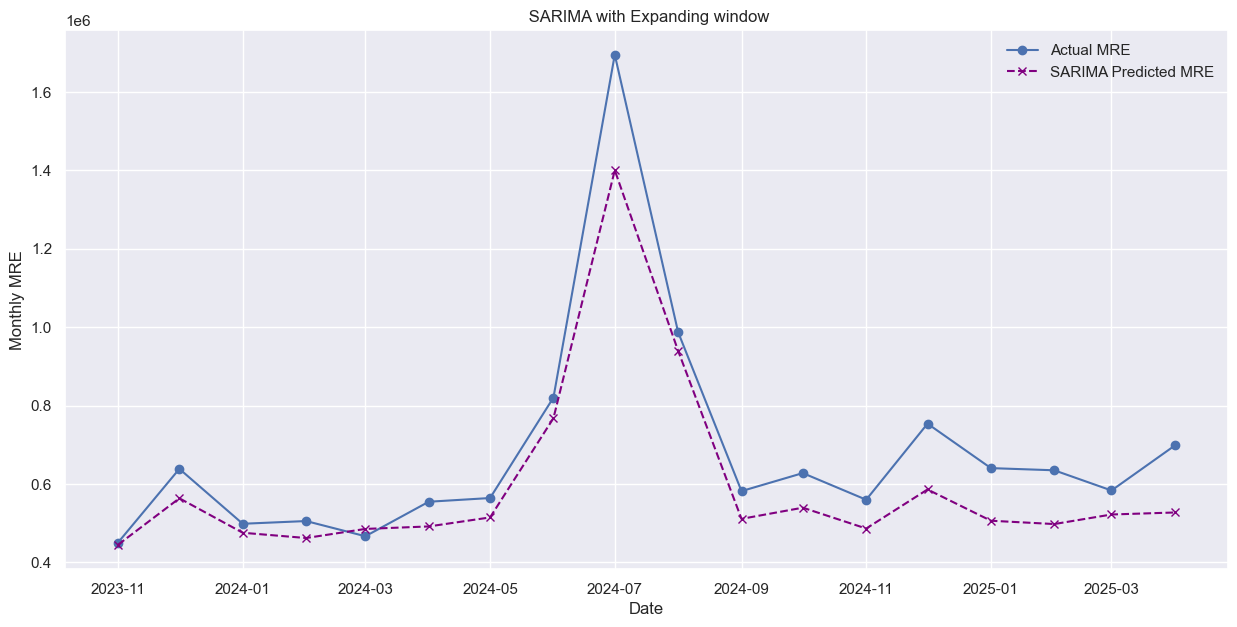

In [35]:
# Plot predictions vs. actuals
plt.figure(figsize=(15, 7))
plt.plot(results2.index, results2['actual'].values, label='Actual MRE', marker='o', linestyle='-')
plt.plot(results2.index, results2['predicted'].values, label='SARIMA Predicted MRE', marker='x', linestyle='--', color='purple')
plt.title(' SARIMA with Expanding window')
plt.xlabel('Date')
plt.ylabel('Monthly MRE')
plt.legend()
plt.grid(True)
plt.show()

# Total Arrivées

In [ ]:
tot_pred=predictions+predictions_MRE

In [69]:
mae = mean_absolute_error(df1['Total Arrivées'].loc['12-2023':'04-2025'], tot_pred)
rmse = root_mean_squared_error(df1['Total Arrivées'].loc['12-2023':'04-2025'], tot_pred)
r2 = r2_score(df1['Total Arrivées'].loc['12-2023':'04-2025'], tot_pred)
mape = 100 * np.mean(np.abs((np.array(df1['Total Arrivées'].loc['12-2023':'04-2025']) - np.array(tot_pred)) / np.array(df1['Total Arrivées'].loc['12-2023':'04-2025'])))

print("="*40,"Mrtric","="*40)
print(f"MAE: {mae:,.1f} \nRMSE: {rmse:,.1f} \nMAPE: {mape:,.1f}%")
print(f"R²: {r2:,.2f}")


======================================== Mrtric ========================================
MAE: 176,511.3 
RMSE: 195,996.7 
MAPE: 12.1%
R²: 0.67


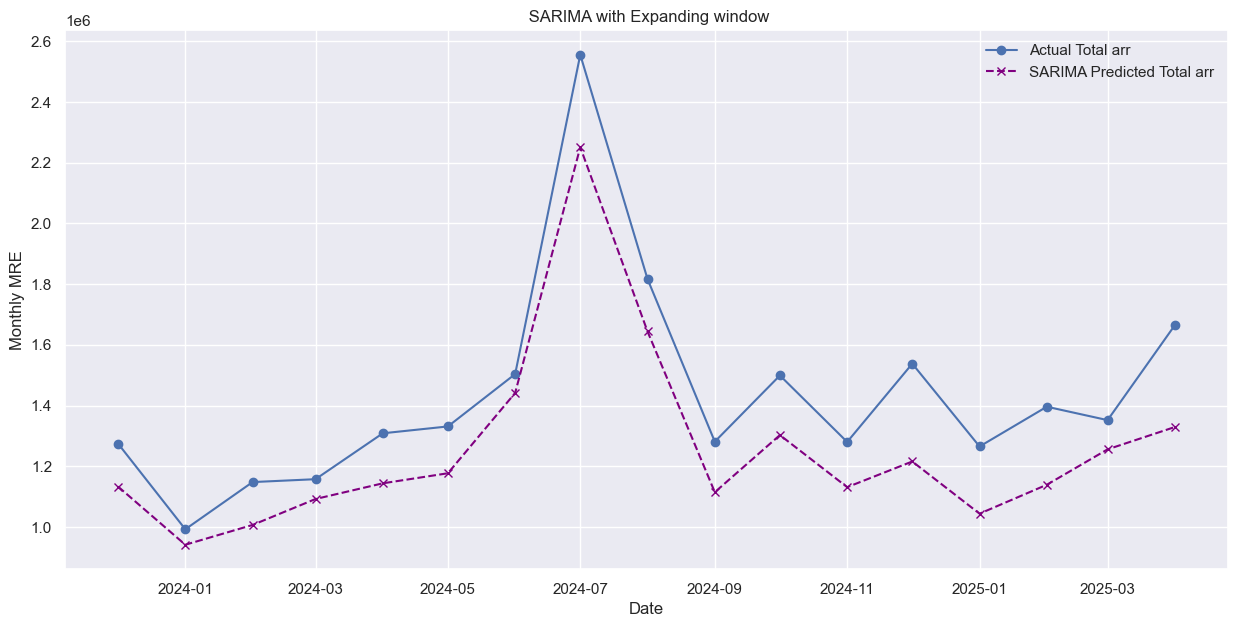

In [70]:
# Plot predictions vs. actuals
plt.figure(figsize=(15, 7))
plt.plot(df1['Total Arrivées'].loc['12-2023':'04-2025'].index, df1['Total Arrivées'].loc['12-2023':'04-2025'].values, label='Actual Total arr', marker='o', linestyle='-')
plt.plot(df1['Total Arrivées'].loc['12-2023':'04-2025'].index, tot_pred.values, label='SARIMA Predicted Total arr', marker='x', linestyle='--', color='purple')
plt.title(' SARIMA with Expanding window')
plt.xlabel('Date')
plt.ylabel('Monthly MRE')
plt.legend()
plt.grid(True)
plt.show()

# Nuité

<Axes: xlabel='Nuité', ylabel='Count'>

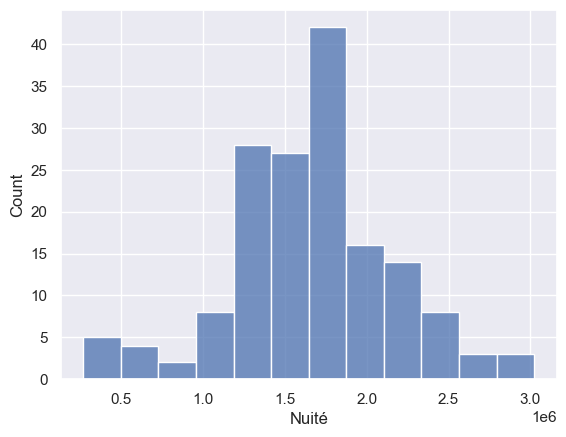

In [55]:
sns.histplot(df1,x="Nuité")

In [54]:
# Graphique interactif
fig = px.line(
    df1,
    x=df1.index,
    y='Nuité',  # remplace 'value' par le nom réel de ta colonne
    title='Évolution mensuelle des arrivées des touristes étrangers de séjour (TES)',
)

# Personnalisation du style
#fig.update_traces(line=dict(color='sky blue', width=2), opacity=0.8)

fig.show()

In [ ]:
train_N=df1.loc['01-2010':'11-2023']
test_N=df1.loc['12-2023':'04-2025']
print("taille du train:",len(train_N),"\ntaille du test :",len(test_N))

taille du train: 167 
taille du test : 17


In [58]:
def grid_search_sarima(train_data, colonne,
                       p_range=range(0, 3), d_range=range(1,2), q_range=range(0, 3),
                       P_range=range(0, 2), D_range=range(0, 2), Q_range=range(0, 2),
                       s=[12]):
    print("\n" + "="*70)
    print("GRID SEARCH SARIMA - VERSION OPTIMISÉE")
    print("="*70)
    # Générer toutes les combinaisons
    pdq = list(itertools.product(p_range, d_range, q_range))
    seasonal_pdq = list(itertools.product(P_range, D_range, Q_range, s))
    
    total_models = len(pdq) * len(seasonal_pdq)
    print(f"\nNombre total de modèles à tester: {total_models}")
    print("Démarrage de la recherche...\n")
    # Variables pour stocker uniquement le meilleur
    meilleur_aic = np.inf
    meilleur_modele = None
    meilleur_params = None
    meilleur_params_seasonal = None
    meilleur_bic = None
    
    compteur = 0
    modeles_testes = 0
    
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            compteur += 1
            
            try:
                # Ajuster le modèle
                model = SARIMAX(train_data[colonne],
                               order=param,
                               seasonal_order=param_seasonal)
                
                results = model.fit(disp=False, maxiter=200)
                modeles_testes += 1
                
                # Garder uniquement si c'est le meilleur
                if results.aic < meilleur_aic:
                    meilleur_aic = results.aic
                    meilleur_bic = results.bic
                    meilleur_modele = results
                    meilleur_params = param
                    meilleur_params_seasonal = param_seasonal
                    
                    # Afficher quand on trouve un meilleur modèle
                    print(f"  ✓ Nouveau meilleur: SARIMA{param}x{param_seasonal} - AIC: {results.aic:.2f}")
                
                # Afficher progression
                if compteur % 10 == 0 or compteur == total_models:
                    print(f"  Progression: {compteur}/{total_models} combinaisons testées ({modeles_testes} réussies)...")
                
            except Exception as e:
                # Ignorer les modèles qui ne convergent pas
                continue
    
    # Vérifier qu'au moins un modèle a convergé
    if meilleur_modele is None:
        raise ValueError("❌ Aucun modèle n'a convergé ! Essayez avec des plages de paramètres différentes.")
    
    print("\n" + "="*70)
    print("🏆 MEILLEUR MODÈLE TROUVÉ")
    print("="*70)
    print(f"SARIMA{meilleur_params}x{meilleur_params_seasonal}")
    print(f"AIC: {meilleur_aic:.2f}")
    print(f"BIC: {meilleur_bic:.2f}")
    print(f"\nModèles testés avec succès: {modeles_testes}/{total_models}")
    
    return {
        'params': meilleur_params,
        'seasonal_params': meilleur_params_seasonal,
        'aic': meilleur_aic,
        'bic': meilleur_bic,
        'model': meilleur_modele
    }

In [ ]:
meilleur_N = grid_search_sarima(train_N,'Nuité')


GRID SEARCH SARIMA - VERSION OPTIMISÉE

Nombre total de modèles à tester: 72
Démarrage de la recherche...

  ✓ Nouveau meilleur: SARIMA(0, 1, 0)x(0, 0, 0, 12) - AIC: 4115.14
  ✓ Nouveau meilleur: SARIMA(0, 1, 0)x(0, 0, 1, 12) - AIC: 4053.32
  ✓ Nouveau meilleur: SARIMA(0, 1, 0)x(0, 1, 0, 12) - AIC: 3977.59
  ✓ Nouveau meilleur: SARIMA(0, 1, 0)x(0, 1, 1, 12) - AIC: 3958.81
  ✓ Nouveau meilleur: SARIMA(0, 1, 0)x(1, 1, 1, 12) - AIC: 3952.60
  Progression: 10/72 combinaisons testées (10 réussies)...
  ✓ Nouveau meilleur: SARIMA(0, 1, 1)x(0, 1, 0, 12) - AIC: 3940.10
  ✓ Nouveau meilleur: SARIMA(0, 1, 1)x(1, 1, 1, 12) - AIC: 3929.23
  Progression: 20/72 combinaisons testées (20 réussies)...
  ✓ Nouveau meilleur: SARIMA(0, 1, 2)x(1, 1, 1, 12) - AIC: 3923.93
  Progression: 30/72 combinaisons testées (30 réussies)...
  Progression: 40/72 combinaisons testées (40 réussies)...
  ✓ Nouveau meilleur: SARIMA(1, 1, 2)x(1, 1, 1, 12) - AIC: 3920.53
  Progression: 50/72 combinaisons testées (50 réussie

In [ ]:
model_N = SARIMAX(train_N["Nuité"],order=meilleur_N['params'],seasonal_order=meilleur_N['seasonal_params'])
results_N = model_N.fit(disp=False)

In [62]:
predictions_N = results_N.predict(start=test_N.index[0], end=test_N.index[-1])

In [63]:
rmse = root_mean_squared_error(test_N['Nuité'], predictions_N)
r2 = r2_score(test_N['Nuité'], predictions_N)
mae = mean_absolute_error(test_N['Nuité'], predictions_N)
mape = mean_absolute_percentage_error(test_N['Nuité'], predictions_N)

print("="*15,"Metrics Test","="*15)
print(f"RMSE: {rmse:,.2f}")
print(f"MAE: {mae:,.2f}")
print(f"MAPE: {mape:,.2%}")
print(f"R²: {r2:,.2%}")
print(f"R²: {r2:,.4f}")

=============== Metrics Test ===============
RMSE: 249,201.04
MAE: 215,245.02
MAPE: 10.57%
R²: 33.95%
R²: 0.3395


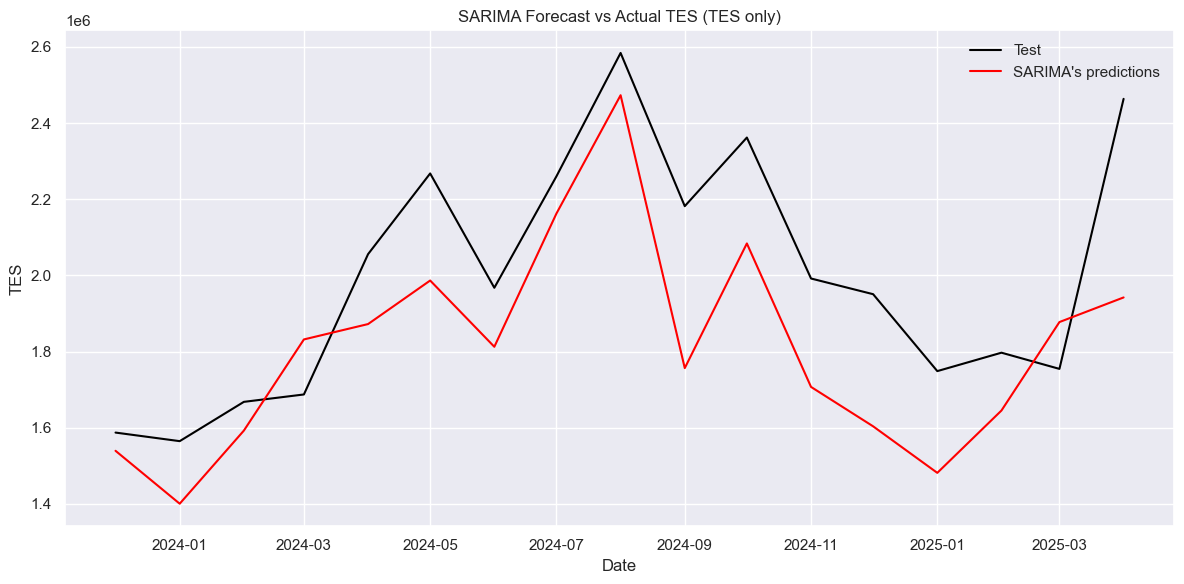

In [65]:
#Visualization
plt.figure(figsize=(12,6))
plt.plot(test_N.index, test_N['Nuité'], label='Test', color='black')
plt.plot(predictions_N.index, predictions_N, label='SARIMA\'s predictions', color='red')
plt.title("SARIMA Forecast vs Actual TES (TES only)")
plt.xlabel("Date")
plt.ylabel("TES")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Expanding window

In [66]:
# Expanding window avec contraintes réelles  
def forecast(df, target, test=18):
    
    train_end = len(df) - test
    preds, acts , dates = [],[], []
    
    for i in range(test):
        # Train
        train = df.iloc[:train_end + i]
        y_train =  train[target]
        
        model = SARIMAX(y_train,order=(2,1,2),seasonal_order=(1,1,1,12))
        results = model.fit(disp=False,maxiter=200)#, cov_type='robust')
        
        # Test avec contrainte réelle
        test_row = df.iloc[[train_end + i]].copy()
        start_index = test_row.index.min()
        end_index = test_row.index.max()
        pred = results.predict(start=start_index, end=end_index)[0]

        preds.append(pred)
        acts.append(df.iloc[train_end + i][target])
        dates.append(df.index[train_end + i])
    
    # Métriques
    mae = mean_absolute_error(acts, preds)
    rmse = root_mean_squared_error(acts, preds)
    r2 = r2_score(acts, preds)
    mape = 100 * np.mean(np.abs((np.array(acts) - np.array(preds)) / np.array(acts)))
    
    print("="*40,"Mrtric","="*40)
    print(f"MAE: {mae:,.1f} \nRMSE: {rmse:,.1f} \nMAPE: {mape:,.1f}%")
    print(f"R²: {r2:,.2f}")
    return pd.DataFrame({'actual': acts, 'predicted': preds} , index=dates)


In [67]:
results3=forecast(df1,'Nuité', test=18)

======================================== Mrtric ========================================
MAE: 147,745.0 
RMSE: 181,067.7 
MAPE: 7.6%
R²: 0.66


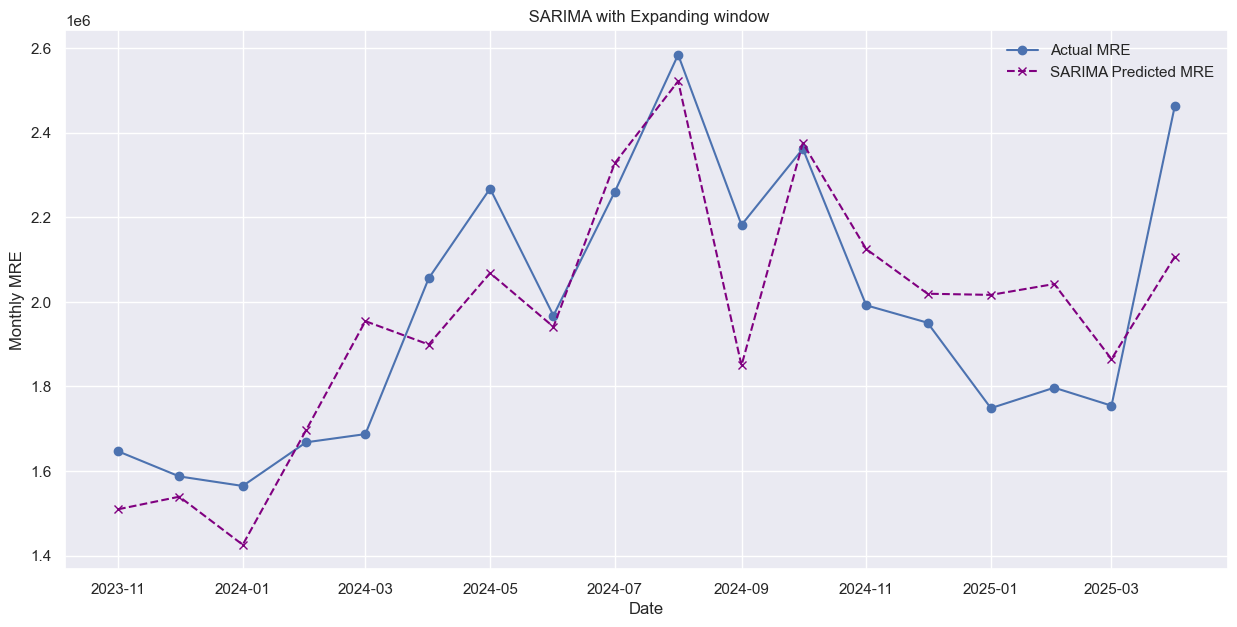

In [68]:
# Plot predictions vs. actuals
plt.figure(figsize=(15, 7))
plt.plot(results3.index, results3['actual'].values, label='Actual MRE', marker='o', linestyle='-')
plt.plot(results3.index, results3['predicted'].values, label='SARIMA Predicted MRE', marker='x', linestyle='--', color='purple')
plt.title(' SARIMA with Expanding window')
plt.xlabel('Date')
plt.ylabel('Monthly MRE')
plt.legend()
plt.grid(True)
plt.show()